In [ ]:
# Multimodal A.I. CLIP+VQGAN

!git clone https://github.com/openai/CLIP.git
#Learning Transferable Visual Models From Natural Language Supervision
!git clone https://github.com/CompVis/taming-transformers
#Taming Transformers for High-Resolution Image Synthesis

Cloning into 'CLIP'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 133 (delta 18), reused 26 (delta 13), pack-reused 91
Receiving objects: 100% (133/133), 8.82 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 756, done.
remote: Total 756 (delta 0), reused 0 (delta 0), pack-reused 756
Receiving objects: 100% (756/756), 202.21 MiB | 45.44 MiB/s, done.
Resolving deltas: 100% (188/188), done.


In [ ]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=454306e36741aaebe67351fbc793b4dabae9bba8682b46785046e41367156bf9
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
     |████████████████████████████████| 561 kB 8.3 MB/s 
     |████████████████████████████████| 829 kB 47.6 MB/s 
     |████████████████████████████████| 636 kB 46.4 MB/s 
     |████████████████████████████████| 118 kB 75.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=02e9b5953ede83fb3503a8d3d1978e7ebe9d48721ea769054cb8ce078184a0d7
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  

In [ ]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml 
from omegaconf import OmegaConf

from CLIP import clip

#import warnings
#warnings.filterwarnings('ignore')


In [ ]:
def ShowFromTensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def NormData(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters 
learning_rate = .5
batch_size = 1
wd = .1 ## weight decay is regularization parameter, help to limit the size of weight and improve generalization capabilities of the architecture
noise_factor = .22 ## .1

total_iter=100 ## use more no. of iterations for more polished result 
im_shape = [450, 450, 3] # height, width, channel
size1, size2, channels = im_shape

In [ ]:
### CLIP MODEL ### 
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval()
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache()

100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 20.7MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
Clip model visual input resolution:  224


In [ ]:
## Taming transformer instantiation

%cd taming-transformers/

!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c481768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed3831bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml' 


/content/taming-transformers
--2021-08-15 08:08:37--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/62510d5b-17cc-4dbc-bdc1-7f74ad266301/last.ckpt [following]
--2021-08-15 08:08:38--  https://heibox.uni-heidelberg.de/seafhttp/files/62510d5b-17cc-4dbc-bdc1-7f74ad266301/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  2.34MB/s    in 6m 42s  

2021-08-15 08:15:20 (2.33 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [ ]:
from taming.models.vqgan import VQModel

def LoadConfig(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def LoadVQGAN(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def Generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = LoadConfig("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = LoadVQGAN(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 468kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
### Declare the values that we are going to optimize

class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x28.125x28.125 (450/16, 450/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer



torch.Size([1, 256, 28, 28])
img dimensions:  torch.Size([1, 3, 448, 448])


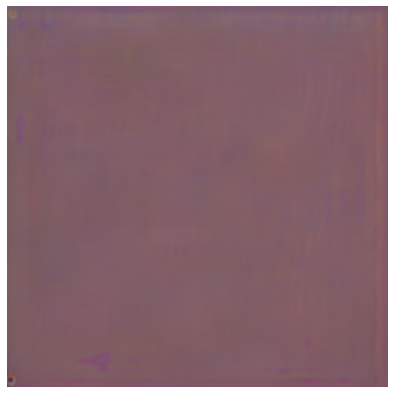

In [ ]:
### Encoding prompts and a few more things
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)  
).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img= NormData(Generator(Params()).cpu()) # 1 x 3 x 450 x 450 [450 x 450]
  print("img dimensions: ",img.shape)
  ShowFromTensor(img[0])



In [ ]:
### create crops

def createCrops(img, num_crops=32): 
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 672 x 672 (adding 112*2 on all sides to 448x448)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32
  
  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops




In [ ]:
### Show current state of generation

def showMe(Params, show_crop):
  with torch.no_grad():
    generated = Generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400 
      aug_gen = createCrops(aug_gen, num_crops=1)
      aug_gen_norm = NormData(aug_gen[0])
      ShowFromTensor(aug_gen_norm)

    print("Generation")
    latest_gen=NormData(generated.cpu()) # 1 x 3 x 224 x 400
    ShowFromTensor(latest_gen[0])

  return (latest_gen[0]) 

In [ ]:
# Optimization process

def optimizeResult(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  ## image encoding
  out = Generator(Params())
  out = NormData(out)
  out = createCrops(out)
  out = normalize(out) # 32 x 3 x 448 x 448
  image_enc=clipmodel.encode_image(out) ## 32 x 512

  ## text encoding  w1 and w2
  final_enc = w1*prompt + w1*extras_enc # prompt and extras_enc : 1 x 512
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  ## calculate the loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 32
  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) # 32

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

def Optimize(Params, optimizer, prompt):
  loss = optimizeResult(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
### training loop

def training_loop(Params, optimizer, show_crop=False):
  res_img=[]
  res_z=[]

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = Optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = showMe(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\nno. of iteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z
  

Augmented cropped example


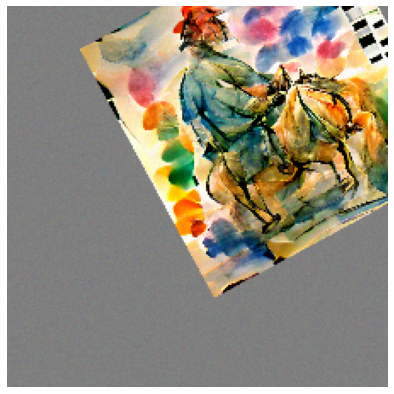

Generation


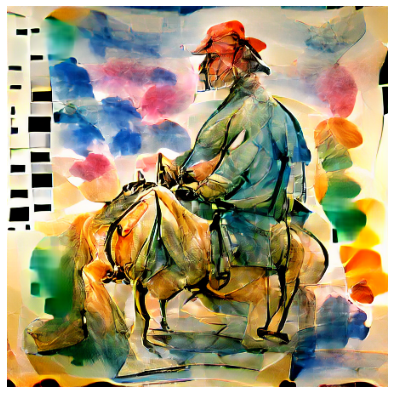

loss: -0.251953125 
no. of iteration: 100
Augmented cropped example


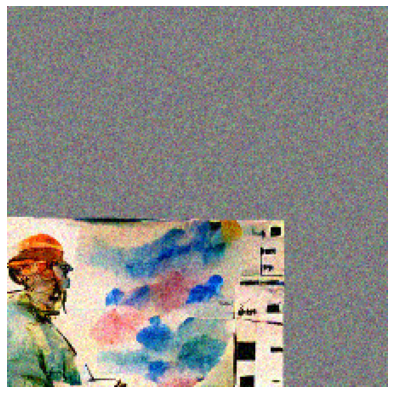

Generation


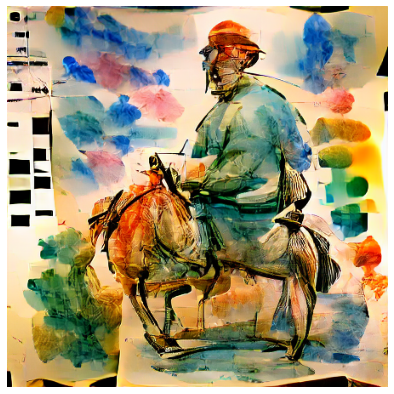

loss: -0.245361328125 
no. of iteration: 200
Augmented cropped example


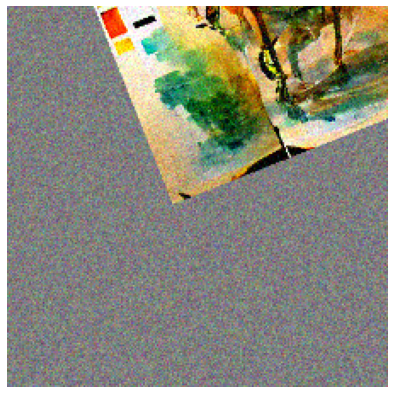

Generation


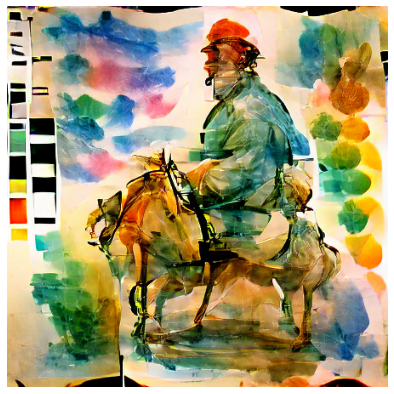

loss: -0.26806640625 
no. of iteration: 300
Augmented cropped example


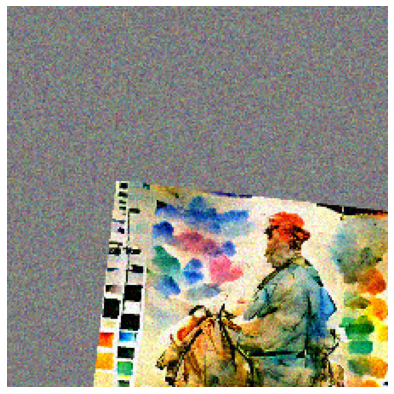

Generation


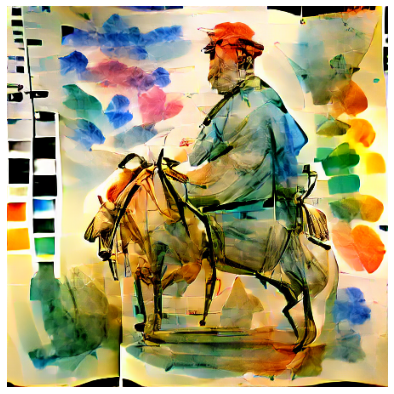

loss: -0.2464599609375 
no. of iteration: 400
Augmented cropped example


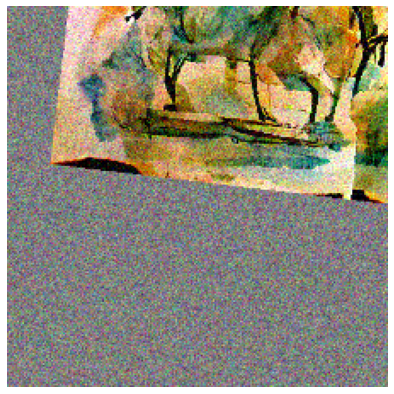

Generation


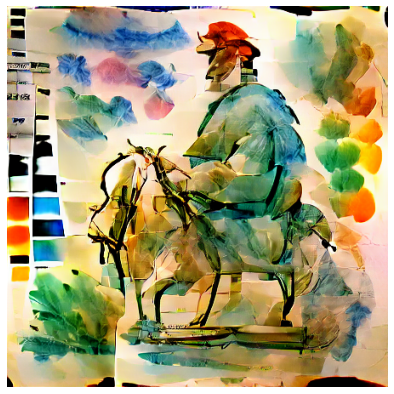

loss: -0.257080078125 
no. of iteration: 500
Augmented cropped example


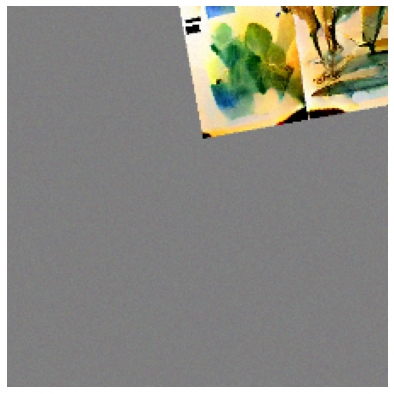

Generation


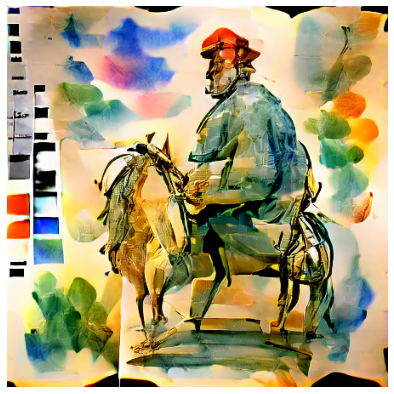

loss: -0.252197265625 
no. of iteration: 600
Augmented cropped example


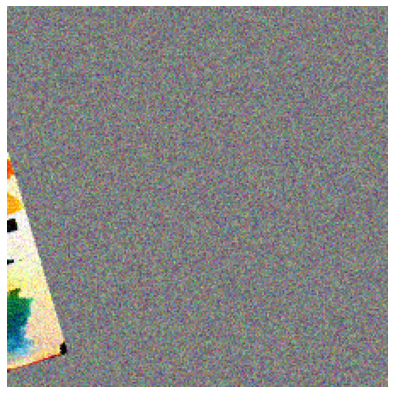

Generation


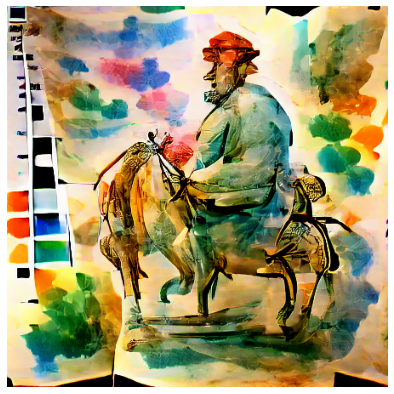

loss: -0.2423095703125 
no. of iteration: 700
Augmented cropped example


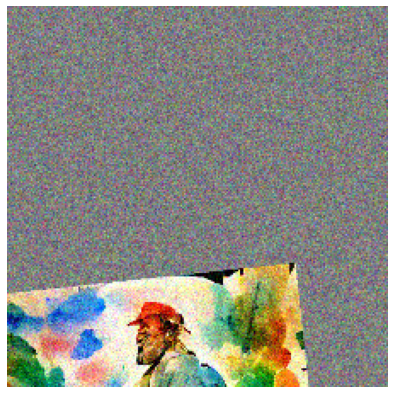

Generation


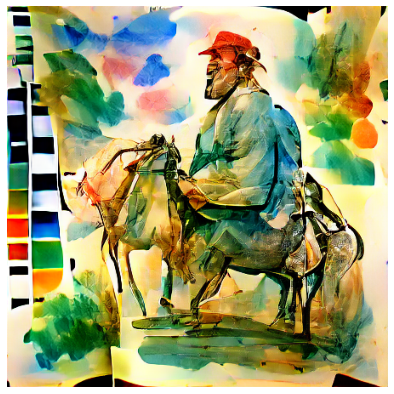

loss: -0.235595703125 
no. of iteration: 800
Augmented cropped example


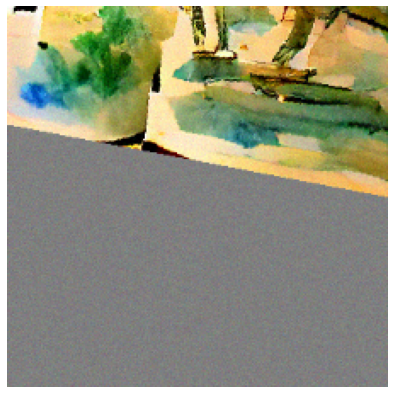

Generation


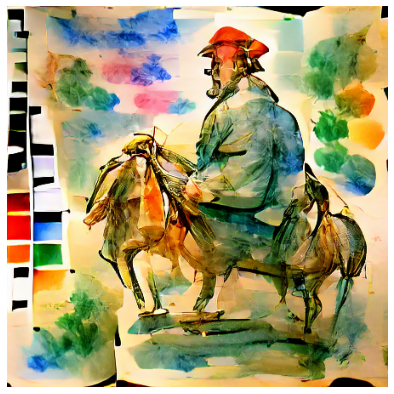

loss: -0.245361328125 
no. of iteration: 900


In [ ]:
torch.cuda.empty_cache()
#include=['sketch of a lady', 'sketch of a man on a horse']
include=['Sketch of a man on a horse']
exclude='watermark, cropped, confusing, blurry'
extras = "watercolor paper"
w1=1
w2=1
noise_factor= .22
total_iter=1000
show_step=100 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


In [ ]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

9 9
torch.Size([3, 448, 448]) torch.Size([1, 256, 28, 28])
tensor(6.0863, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-6.1343, device='cuda:0', grad_fn=<MinBackward1>)


Augmented cropped example


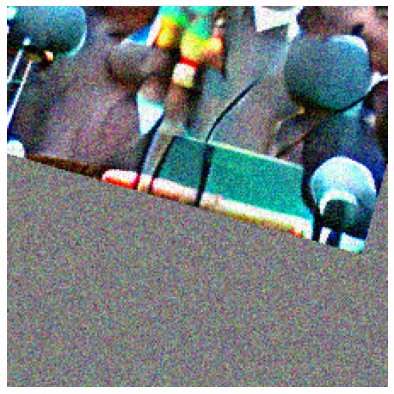

Generation


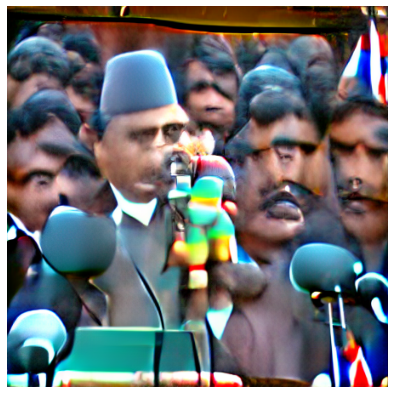

loss: -0.25537109375 
no. of iteration: 100


KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache()
include= ["Primeminister giving speech in front of people"]
exclude= "Watermark, blurry, cropped, confusing, cut, incoherent"
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=200
# show_step=100 # set this to see the result every 100 interations
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)

Generation


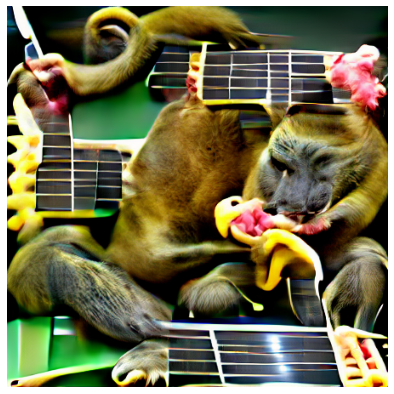

loss: -0.33984375 
iteration: 999


In [ ]:
torch.cuda.empty_cache()
include=['A monkey playing guitar','A greatest singer performing in the stage, infront of thousands people']
exclude='watermark, cropped, confusing, incoherent, cut, blurry'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=1000
show_step=total_iter-1 # set this if you want to interpolate between only the final versions
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=False)


In [ ]:
def Interpolate(res_z_list, duration_list):
  gen_img_list=[]
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1-alpha) * z1

      new_gen=NormData(Generator(z_new).cpu())[0] ## 3 x 224 x 400
      new_img=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations=[5,5,5,5,5,5]
interp_result_img_list = Interpolate(res_z, durations)

RuntimeError: ignored

In [ ]:
## create a video
out_video_path=f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=30)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)